In [10]:
!pip install hickle

     |████████████████████████████████| 49 kB 1.2 MB/s            
     |████████████████████████████████| 2.9 MB 3.3 MB/s            
     |████████████████████████████████| 86 kB 1.3 MB/s             
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.5.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.


In [1]:
import os
import pandas as pd
import shutil
import tempfile
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import numpy as np
import PIL
from PIL import Image, ImageChops, ImageDraw
import torch
from torch import nn
import torchvision.models
import cv2

from pathlib import Path

import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches

from tqdm import tqdm

In [22]:
!nvidia-smi

Sun Jun  5 22:39:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   31C    P8    25W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

### Load Model

In [39]:
fundus_classifier = keras.models.load_model('models/ROP-256x25680-20-split-resnet18-Float16_2-race_detection_rop_seg_data_fundus_rop_seg-0.001_20220419-040552_epoch:021.hdf5')

In [40]:
fundus_classifier

In [2]:
segmentation_classifier = keras.models.load_model('models/MIMIC-256x25680-20-split-resnet-Float16_2-race_detection_rop_seg_data_rop_seg-0.001_20220321-054140_epoch:011.hdf5')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [48]:
fundus_classifier.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_18[0][0]          
_______________________________________________________________________________________

In [46]:
segmentation_classifier.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_68 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_68[0][0]          
______________________________________________________________________________________

## Test Classifier

In [3]:
img_class = Image.open("/users/riya/race/dataset/segmentations/7445.bmp")

In [4]:
arr_class = np.array(img_class)

In [5]:
resized_class = cv2.resize(arr_class, (256, 256))

### Method 1: 2D image repeated thrice - to make three channels

In [6]:
channels_class = np.repeat(resized_class[:, :, np.newaxis], 3, axis=2).reshape((1,256,256,3))

In [9]:
arr_class.shape, resized_class.shape, channels_class.shape

((480, 640), (256, 256), (1, 256, 256, 3))

In [10]:
# unnecessary 
tensor = tf.convert_to_tensor(channels_class)

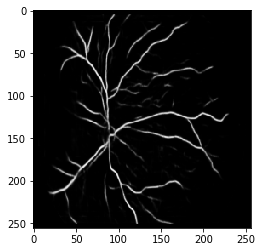

In [11]:
plt.imshow(np.reshape(channels_class, (256, 256, 3)), interpolation='nearest')
plt.show()

In [12]:
# right pred 
segmentation_classifier(channels_class)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0647717, 0.9352283]], dtype=float32)>

In [16]:
tensor_class = segmentation_classifier(channels_class)

In [17]:
tensor_class

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0647717, 0.9352283]], dtype=float32)>

In [18]:
tensor_class.numpy()[0,1]

0.9352283

## Thresholding Functions

In [3]:
# darn, should I have just used a clip function instead of writing my own (probably)

def shadow_threshold(c, operation, none_thresh, increment):
    if (c < none_thresh): # just to write it explicitly
        c = c
    else:
        if (operation == 'add'):
            sum = c + increment
            if (sum > 255):
                sum = 255
            c = sum
        if (operation == 'subtract'):
            difference = c - increment
            if (difference < 0):
                difference = 0
            c = difference
    return c

In [4]:
def apply_threshold(image, operation):
    
    img_arr = np.copy(image)
    
    for i in range(img_arr.shape[0]):
        for j in range(img_arr.shape[1]):
            new_cell = shadow_threshold(img_arr[i][j], operation, 20, 65) # final values chosen
            img_arr[i][j] = new_cell
    
    return img_arr

## Test Thresholding

In [5]:
img_thresh = np.array(Image.open("/users/riya/race/dataset/segmentations/7445.bmp"))

In [6]:
img_thresh = cv2.resize(img_thresh, (256, 256))

In [7]:
channels_thresh = np.repeat(img_thresh[:, :, np.newaxis], 3, axis=2).reshape((1,256,256,3))

In [8]:
channels_thresh.shape

(1, 256, 256, 3)

In [9]:
img_thresh_display = np.reshape(channels_thresh, (256, 256, 3))

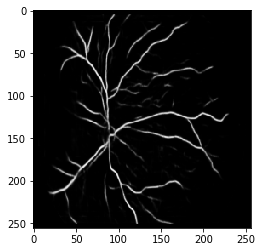

In [10]:
plt.imshow(img_thresh_display, interpolation='nearest')
plt.show()

In [11]:
# mask
mask = np.full((256, 256), 0, dtype=np.uint8)
cv2.circle(mask, (128, 128), 50, (255, 255, 255), -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

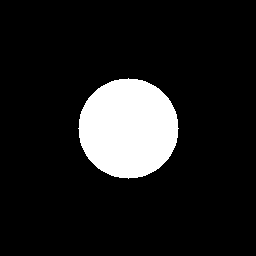

In [12]:
display(Image.fromarray(mask))

In [13]:
fg = cv2.bitwise_or(img_thresh, img_thresh, mask=mask)

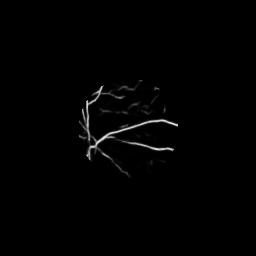

In [14]:
display(Image.fromarray(fg))

In [15]:
test1 = apply_threshold(fg, 'add')

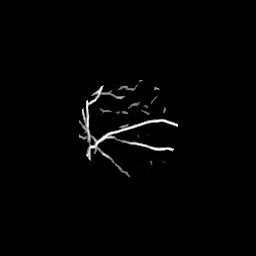

In [16]:
display(Image.fromarray(test1))

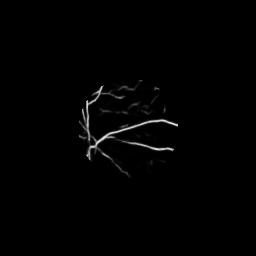

In [17]:
display(Image.fromarray(fg))

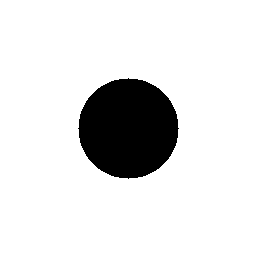

In [18]:
mask1 = cv2.bitwise_not(mask)
display(Image.fromarray(mask1))

In [19]:
bg = cv2.bitwise_or(img_thresh, img_thresh, mask=mask1)

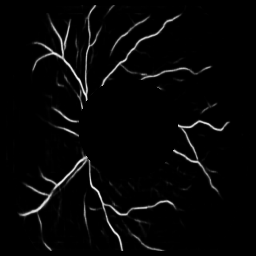

In [20]:
display(Image.fromarray(bg))

In [21]:
bg.shape

(256, 256)

In [22]:
test2 = apply_threshold(bg, 'subtract')

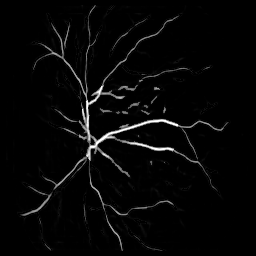

In [23]:
display(Image.fromarray(test1 + test2))

Ok! We know what we want :)

## High Intensity Pixel Images

I need to take images and black out pixels of highest intensity in main and background regions. To do this, I'll first choose some number of images with similar main and background locations (manually), load those into my new folder, and remove high intensity pixels there.

Images: 7393, 7419, 7420, 7423, 7568, 7571, 7575, 7578, 9135, 9153, 9378, 9394, 9540, 9556, 12013, 12018, 12487, 12488, 15880, 18163

### Load Images

In [2]:
csv_path = "/users/riya/race/csv/image_race_data.csv"
data_path = "/users/riya/race/dataset/segmentations/"
intensity_path = "/users/riya/race/classifier_experiments/dataset/high_intensity_experiment3/original/"

In [3]:
def get_images(csv_path, load_path, save_path):
    
    new_df = pd.DataFrame()
    data = pd.read_csv(csv_path)
    df1 = data.loc[data['variable'] == 'posterior'].reset_index(drop=True)
        
    for i in range(len(df1)):
        img_id = df1['image_id'][i]
        a = shutil.copy(load_path + str(img_id) + '.bmp', save_path) # solely copying segmentations
    
    return df1

In [4]:
data_posterior = get_images(csv_path, data_path, intensity_path)

In [5]:
data_posterior

,subject_id,race,variable,value,image_id,fundus_location,segmentation_location
0,BEAU-0002,black,posterior,https://tctc.ohsu.edu/uploads/30121.bmp,30121,30121.png,30121.bmp
1,BEAU-0003,white,posterior,https://tctc.ohsu.edu/uploads/30672.bmp,30672,30672.png,30672.bmp
2,BEAU-0003,white,posterior,https://tctc.ohsu.edu/uploads/30676.bmp,30676,30676.png,30676.bmp
3,BEAU-0004,white,posterior,https://tctc.ohsu.edu/uploads/30630.bmp,30630,30630.png,30630.bmp
4,BEAU-0006,white,posterior,https://tctc.ohsu.edu/uploads/30696.bmp,30696,30696.png,30696.bmp
...,...,...,...,...,...,...,...
1030,RCOL-0042-EW,white,posterior,https://tctc.ohsu.edu/uploads/7578.png,7578,7578.png,7578.bmp
1031,RCOL-0055-GJ,black,posterior,https://tctc.ohsu.edu/uploads/7715.png,7715,7715.png,7715.bmp
1032,RCOL-0055-GJ,black,posterior,https://tctc.ohsu.edu/uploads/7718.png,7718,7718.png,7718.bmp
1033,RCOL-0060,black,posterior,https://tctc.ohsu.edu/uploads/7759.png,7759,7759.png,7759.bmp


In [6]:
white_posterior = data_posterior[data_posterior['race'] == 'white'].reset_index(drop=True)
black_posterior = data_posterior[data_posterior['race'] == 'black'].reset_index(drop=True)

In [7]:
len(white_posterior), len(black_posterior) # good sizes!

(627, 408)

I will work with black/white separately. So in the end, I'm running my main function four times. 
1. white: center brighter
2. white: outside brighter
3. black: center brighter
4. black: outside brighter

Will group into two tables of center brighter and outside brighter.

### Find Four Radiuses 

In [28]:
def find_radiuses(data, load_path, radius_arr):
    for i in range(len(data)):
        img_id = data['image_id'][i]
        
        if img_id == 9131:
            img = Image.open(load_path + str(img_id) + '.bmp')
            resized = cv2.resize(np.array(img), (224, 224))
            channels = np.repeat(resized[:, :, np.newaxis], 3, axis=2).reshape((224,224,3))


            f, axarr = plt.subplots(1,1)
            plt.gcf().set_size_inches(10, 10)
            axarr.imshow(channels)

            # threshold region boxes, test
            for i in radius_arr:
                circle = patches.Circle((224/2, 224/2), i, linewidth=2, edgecolor='r', facecolor='none')
                axarr.add_patch(circle)

            plt.show()

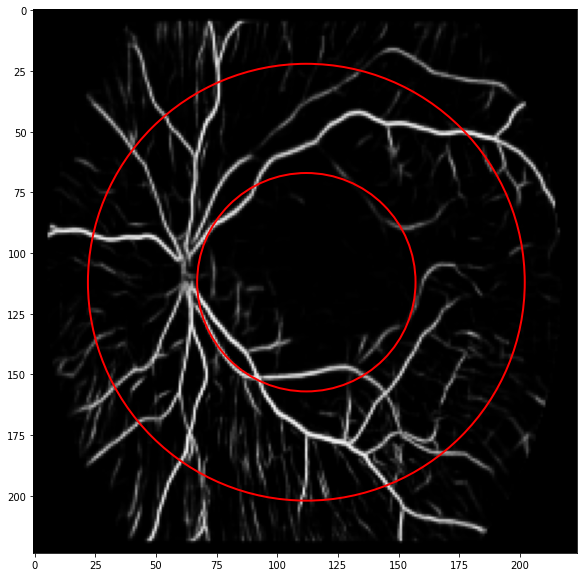

In [29]:
find_radiuses(data_posterior, intensity_path, [45, 90]) 
# larger first radius, because most images, even posterior, aren't aligned right with the center

### Shadow Images

In [11]:
bright_center_path = "/users/riya/race/classifier_experiments/dataset/high_intensity_experiment3/bright_center/"
bright_back_path = "/users/riya/race/classifier_experiments/dataset/high_intensity_experiment3/bright_back/"

In [12]:
def threshold_images(data, load_path, save_path, radius_arr, region, race):
    
    for r in tqdm(radius_arr):
        # developing mask that isolates center portion
        center_mask = np.full((256, 256), 0, dtype=np.uint8) 
        # radius i changes, center, color, fill is the same
        cv2.circle(center_mask, (128, 128), r, (255, 255, 255), -1)

        # developing mask that isolates background region
        back_mask = cv2.bitwise_not(center_mask)
  
        for i in range(len(data)):
            img_id = data['image_id'][i]
            
            img = np.array(Image.open(load_path + str(img_id) + '.bmp'))
            resized = cv2.resize(img, (256, 256))

            # applying center_mask
            center = cv2.bitwise_or(resized, resized, mask=center_mask)
            # applying background mask
            background = cv2.bitwise_or(resized, resized, mask=back_mask)

            if (region == 'bright_center'):
                # bright center means we add to the center and subtract from back
                bright_center = apply_threshold(center, 'add')
                dull_back = apply_threshold(background, 'subtract')

                final_center = bright_center + dull_back
                
                # saving the image
                final_center = Image.fromarray(final_center)
                # different folder per radius
                final_center.save(save_path + str(race) + '/' + str(r) + '/' + str(img_id) + '.bmp')

            if (region == 'bright_back'):
                # bright center means we add to the back and subtract from center
                bright_back = apply_threshold(background, 'add')
                dull_center = apply_threshold(center, 'subtract')

                final_back = bright_back + dull_center
                           
                # saving the image
                final_back = Image.fromarray(final_back)
                # different folder per radius
                final_back.save(save_path + str(race) + '/' + str(r) + '/' + str(img_id) + '.bmp')

In [14]:
# white bright back
threshold_images(white_posterior, intensity_path, bright_back_path, [0], 'bright_back', 'white')

100%|██████████| 1/1 [03:01<00:00, 181.93s/it]


In [15]:
# black bright back
threshold_images(black_posterior, intensity_path, bright_back_path, [0, 30, 60, 90, 120], 'bright_back', 'black')

100%|██████████| 5/5 [09:58<00:00, 119.80s/it]


### Prepare For Classifier

This is gonna be a long process. I suppose I can start by preparing each radius separately (and thus race separately of course) and saving the results in a bunch of dataframes, which I can then work with individually.

In [13]:
def prepare_for_classification(img_id, img_path, race, radius):
    
    if (radius != None):
        img = Image.open(img_path + str(race) + '/' + str(radius) + '/' + str(img_id) + '.bmp')
    else: # case of original images
        img = Image.open(img_path + str(img_id) + '.bmp')
        
    arr = np.array(img)
    resized = cv2.resize(arr, (256,256)) # for original image
    channels = np.repeat(resized[:, :, np.newaxis], 3, axis=2).reshape((1,256,256,3))
    
    return channels

In [14]:
def combine_images(data, img_path, race, radius):
    
    img_arr = np.zeros([1, 256, 256, 3], dtype='int')

    for i in tqdm(range(len(data))):
        img_id = data['image_id'][i] # because of this, predictions are in the right order, IMPORTANT
        # original preds
        img_prepared = prepare_for_classification(img_id, img_path, race, radius)
        img_arr = np.concatenate((img_arr, img_prepared), axis = 0)
        
    img_arr = img_arr[1:] # removing the unnecessary first element
    
    return img_arr

Just for bright center, let's make 2 dataframes, 1 per race. We'll start by predicting race of the original images, beginning with white. Then we'll predict race for each of the radiuses, make a dataframe (4 at this point). After, we will combine the 5 dataframes -- original and radius predictions -- into one dataframe, where we can then get 1/4 of the information we need. We will save this dataframe as a .csv in the prediction folder.

In [32]:
og_white = combine_images(white_posterior, intensity_path, None, None)

100%|██████████| 627/627 [01:48<00:00,  5.80it/s]


In [35]:
og_white.shape # nice shape ƪ(˘⌣˘)ʃ

(627, 256, 256, 3)

In [ ]:
bright_back_white0 = combine_images(white_posterior, bright_back_path, 'white', 0)
bright_back_white30 = combine_images(white_posterior, bright_back_path, 'white', 30)
bright_back_white60 = combine_images(white_posterior, bright_back_path, 'white', 60)
bright_back_white90 = combine_images(white_posterior, bright_back_path, 'white', 90)
bright_back_white120 = combine_images(white_posterior, bright_back_path, 'white', 120)

 81%|████████  | 505/627 [01:12<00:37,  3.28it/s]

In [36]:
bright_back_white120 = combine_images(white_posterior, bright_back_path, 'white', 120)

100%|██████████| 627/627 [01:48<00:00,  5.78it/s]


In [37]:
bright_back_white0.shape, bright_back_white30.shape, bright_back_white60.shape, bright_back_white90.shape, bright_back_white120.shape

((627, 256, 256, 3),
 (627, 256, 256, 3),
 (627, 256, 256, 3),
 (627, 256, 256, 3),
 (627, 256, 256, 3))

### Run Through Classifier & Predictions

In [38]:
bright_back_white_preds = pd.DataFrame(columns = ['id', 'original', '0', '30', '60', '90', '120'])

In [39]:
white_ids = pd.Series(white_posterior['image_id'])
bright_back_white_preds['id'] = white_ids

In [40]:
bright_back_white_preds.head()

,id,original,0,30,60,90,120
0,30672,NaN,NaN,NaN,NaN,NaN,NaN
1,30676,NaN,NaN,NaN,NaN,NaN,NaN
2,30630,NaN,NaN,NaN,NaN,NaN,NaN
3,30696,NaN,NaN,NaN,NaN,NaN,NaN
4,30712,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
def determine_preds(preds_df, images, colname):

    num_images = images.shape[0]
    preds_arr = [0] * num_images

    preds = segmentation_classifier(images)
    
    for i in tqdm(range(num_images)):
        preds_arr[i] = preds.numpy()[i, 1] # returning the white prediction for each image
    
    preds_df[colname] = preds_arr

In [42]:
determine_preds(bright_back_white_preds, og_white, 'original')

100%|██████████| 627/627 [00:00<00:00, 280754.63it/s]


In [43]:
bright_back_white_preds.head()

,id,original,0,30,60,90,120
0,30672,0.999994,NaN,NaN,NaN,NaN,NaN
1,30676,0.999925,NaN,NaN,NaN,NaN,NaN
2,30630,0.991472,NaN,NaN,NaN,NaN,NaN
3,30696,0.999981,NaN,NaN,NaN,NaN,NaN
4,30712,0.906529,NaN,NaN,NaN,NaN,NaN


In [44]:
len(bright_back_white_preds)

627

In [45]:
determine_preds(bright_back_white_preds, bright_back_white0, '0')
determine_preds(bright_back_white_preds, bright_back_white30, '30')
determine_preds(bright_back_white_preds, bright_back_white60, '60')
determine_preds(bright_back_white_preds, bright_back_white90, '90')
determine_preds(bright_back_white_preds, bright_back_white120, '120')

100%|██████████| 627/627 [00:00<00:00, 266284.79it/s]


Very interesting!

### Save Predictions

In [29]:
def save_df(df, path, name):    
    df.to_csv(path + str(name) + ".csv") 

In [5]:
preds_save_path = "/users/riya/race/classifier_experiments/predictions/high_intensity_experiment3/"

## Analyze Predictions

Loading from predictions folder.

In [5]:
bright_center_white_preds = pd.read_csv(preds_save_path + "white_bright_center_preds.csv", 
                                        usecols = ['id', 'original', '0', '30', '60', '90', '120'])

In [6]:
bright_center_black_preds = pd.read_csv(preds_save_path + "black_bright_center_preds.csv", 
                                        usecols = ['id', 'original', '0', '30', '60', '90', '120'])

In [6]:
bright_back_white_preds = pd.read_csv(preds_save_path + "white_bright_back_preds.csv", 
                                        usecols = ['id', 'original', '0', '30', '60', '90', '120'])

In [8]:
bright_back_black_preds = pd.read_csv(preds_save_path + "black_bright_back_preds.csv", 
                                        usecols = ['id', 'original', '0', '30', '60', '90', '120'])

In [11]:
def percent_predictions(preds_df, race):
    
    pred = ''
    
    if (race == 'black'):
        pred == 'white'
    elif (race == 'white'):
        pred == 'black'
    
    print('Percent of Images Incorrectly Predicted as ' + pred)
    
    def preds_print(colname):
        if (race == 'white'): # getting the percent predicted correctly as white
            predscol = preds_df[preds_df[colname] > 0.5]
        elif (race == 'black'): # getting the percent predicted correctly as black
            predscol = preds_df[preds_df[colname] < 0.5]
            
        right_percent = 100 * len(predscol)/len(preds_df) 
        wrong_percent = 100 - right_percent
        print(str(colname) + ':' + str(wrong_percent))\
    
    preds_print('original')
    preds_print('0')
    preds_print('30')
    preds_print('60')
    preds_print('90')
    preds_print('120')

### Bright Back

#### % white images classified as black

In [14]:
percent_predictions(bright_back_white_preds, 'white')

Percent of Images Incorrectly Predicted as 
original:1.913875598086122
0:67.62360446570973
30:65.7097288676236
60:41.14832535885167
90:3.987240829346092
120:1.4354066985645915


In [7]:
bright_back_white_preds

,id,original,0,30,60,90,120
0,30672,0.999994,0.029873,0.008882,0.163445,0.999288,0.999985
1,30676,0.999925,0.002768,0.002742,0.461502,0.999819,0.999933
2,30630,0.991472,0.025590,0.018282,0.034619,0.969498,0.999462
3,30696,0.999981,0.967101,0.861771,0.960731,0.998221,0.999977
4,30712,0.906529,0.004963,0.001849,0.007039,0.057229,0.747892
...,...,...,...,...,...,...,...
622,7449,0.999748,0.003992,0.006062,0.001648,0.942188,0.999978
623,7568,0.997668,0.005888,0.001890,0.136493,0.966028,0.999595
624,7571,0.995363,0.000374,0.000458,0.003839,0.748858,0.999569
625,7575,0.839931,0.002546,0.001405,0.014785,0.634204,0.998964


In [21]:
test = bright_back_white_preds[bright_back_white_preds['30'] > 0.5]

In [22]:
test

,id,original,0,30,60,90,120
3,30696,0.999981,0.967101,0.861771,0.960731,0.998221,0.999977
5,30766,0.999997,0.976513,0.944536,0.987055,0.999955,0.999994
7,30778,0.999993,0.999478,0.998931,0.999230,0.999536,0.999705
9,30787,0.999992,0.973469,0.878991,0.992934,0.999207,0.999988
12,33747,0.999960,0.748628,0.779909,0.927822,0.998193,0.999779
...,...,...,...,...,...,...,...
588,97310,0.999999,0.983832,0.963575,0.997484,0.999628,0.999968
589,97319,0.999955,0.168036,0.919281,0.964522,0.999011,0.999915
596,100470,0.999415,0.251878,0.846197,0.970964,0.997253,0.999108
611,117149,0.970882,0.933854,0.933854,0.943815,0.856272,0.678726


In [19]:
test > 0.5

,30
0,False
1,False
2,False
3,True
4,False
...,...
622,False
623,False
624,False
625,False


#### % black images classified as white

In [15]:
percent_predictions(bright_back_black_preds, 'black')

Percent of Images Incorrectly Predicted as 
original:0.9803921568627487
0:1.2254901960784252
30:0.9803921568627487
60:1.470588235294116
90:10.539215686274517
120:19.607843137254903


### Bright Center

#### % white images classified as black

In [60]:
bright_center_white_preds.loc[bright_center_white_preds['id'] == 9400]

,id,original,0,30,60,90,120
360,9400,0.904229,0.985828,0.941922,0.379881,0.04747,0.011508


In [12]:
percent_predictions(bright_center_white_preds, 'white')

Percent of Images Incorrectly Predicted as 
original:1.913875598086122
0:1.2759170653907432
30:1.4354066985645915
60:7.655502392344502
90:42.26475279106858
120:66.18819776714514


#### % black images classified as white

In [13]:
percent_predictions(bright_center_black_preds, 'black')

Percent of Images Incorrectly Predicted as 
original:0.9803921568627487
0:22.058823529411768
30:19.362745098039213
60:6.617647058823536
90:1.7156862745098067
120:1.2254901960784252
